## Symptom Detection with BioBERT Implementation
Import and install the necessary packages, and get the file with the data from the Lindvall Lab. Read it into a pandas DataFrame.


In [ ]:
!pip install scipy==1.7.1
from scipy.stats import bootstrap

# choose the file with what you want to upload
from google.colab import files
uploaded = files.upload()

In [ ]:
import numpy as np
import pandas as pd
import io
import torch
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
!pip install nltk

In [ ]:
# here, df_unique is the file with the data that I uploaded in the first cell
df = pd.read_csv(io.BytesIO(uploaded['df_unique.csv']))
df.head()

Clone the git repository with the BioBERT embedding implementation

In [ ]:
# get to the biobert git repo and clone into local runtime
!git clone https://github.com/dmis-lab/biobert-pytorch.git
%cd ./biobert-pytorch/
!pip install transformers==3.0.0
!./download.sh
!pip install h5py
%cd embedding/
!pwd

Data pre-processing. The steps are as follows:


1.   Binarize the ground truth labels on the turns such that turns with avg_symptoms <= 1 go to 0 and the rest go to 1.
2.   Remove stop words and punctuation from the text of each turn



In [ ]:
# re-binarize the turns so they're in [0,1] = 0 and [2, 3] = 1
df.bin_symptoms = np.where(df.avg_symptoms <= 1, 0, 1)
df.head()

In [ ]:
# data pre-processing to get the turns as a list separated by enters
# 1: remove stop words and punctuation
def remove_stopwords_punct(text):
  text_tokens = word_tokenize(text)
  tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('english')]
  tokenizer = RegexpTokenizer(r'\w+')
  no_sw_text = ' '.join(tokens_without_sw)
  tokens_without_punct = tokenizer.tokenize(no_sw_text)
  return " ".join(tokens_without_punct)

df['turn_text'] = df['turn_text'].apply(remove_stopwords_punct)
df = df[df.turn_text != '']
df = df.reset_index(drop=True)

# 2: put each value in the dataframe into a text file that you can load the next time around
with open('symptoms_turn_text.txt', 'w') as f:
    for turn in df.turn_text:
      f.write(turn + '\n')


Run the pre-processed turns through the pre-trained BioBERT embedding module to get a vector of 768 numbers for each turn. Use h5py to read the results into a CSV file that can be saved and loaded into a dataframe.

In [ ]:
!python run_embedding.py \
    --model_name_or_path dmis-lab/biobert-base-cased-v1.1 \
    --max_seq_length  170 \
    --data_path symptoms_turn_text.txt  \
    --output_path keyword_turn_embeddings.h5 \
    --batch_size 64 \
    --pooling mean

In [ ]:
import h5py
# create a dataframe with conversation #, binary classification, embedding and turn text
final_data = pd.DataFrame(columns=['conv_id', 'turn_text', 'embedding', 'binary_symptom'])

count = 0
with h5py.File('turn_embeddings.h5', 'r') as o:
  import pdb
  pdb.set_trace()

  for key in o.keys():
    turn_info = df.loc[df['turn_text'] == key]
    turn_info = turn_info.iloc[0]

    embedding = list(o[key]['embedding'])
    final_data = final_data.append({'conv_id': turn_info.conv_id, 'turn_text': key, 'embedding': embedding, 'binary_symptom': turn_info.bin_symptoms}, ignore_index=True)

    if count % 500 == 0:
      print(count)
    count += 1

final_data.to_csv('/content/biobert-pytorch/embedding/final_data.csv')


# embedding = list(o['About That left side right']['embedding'])


Load the csv file into a dataframe. Note that the length of final data is 55,000, not 79,000 because turns with the same text after pre-processing are combined.


In [ ]:
#  CODE TO LOAD DF FROM CSV #
final_data = pd.read_csv('/content/final_data.csv')
len(final_data)

55073

In [ ]:
# Here's what one line of the dataframe looks like
final_data.loc[final_data['turn_text'] == 'Right first press right I felt right']

Code for defining and training the model for the Linear Classification.
* Note: pt_test, pt_train and pt_val are files shared between group members that contain the way for splitting the patients into the different sets that we all standardized to.

In [ ]:
# TODO train a small classifier to take the embeddings and classify
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
class SymptomClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(768, 64)
    self.layer_2 = nn.Linear(64, 64)
    self.layer_out = nn.Linear(64, 1) 
    
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(p=0.1)
    self.batchnorm1 = nn.BatchNorm1d(64)
    self.batchnorm2 = nn.BatchNorm1d(64)
        
  def forward(self, inputs):
      x = self.relu(self.layer_1(inputs))
      x = self.batchnorm1(x)
      x = self.relu(self.layer_2(x))
      x = self.batchnorm2(x)
      x = self.dropout(x)
      x = self.layer_out(x)
      x = x.squeeze()
      return x


class SymptomDataset(Dataset):
  def __init__(self, npy_file, df, og_df):
      """
      Args:
          csv_file (string): Path to the csv file with annotations.
          root_dir (string): Directory with all the images.
          transform (callable, optional): Optional transform to be applied
              on a sample.
      """
      # npy_file is the file pranav sent to me of patients for a given split
      patients = np.load(npy_file, allow_pickle=True)
      conversations = []
      for patient_id in patients:
        conv_ids = set(og_df.loc[og_df['pt_id'] == patient_id]['conv_id'])
        conversations.extend(list(conv_ids))

      self.turns_df = df.loc[df['conv_id'].isin(conversations)]
      self.turns_df = self.turns_df.reset_index()

  def __len__(self):
      return len(self.turns_df)

  def __getitem__(self, idx):
      if torch.is_tensor(idx):
          idx = idx.tolist()

      turn = self.turns_df.iloc[idx]
      embedding = turn.embedding
      embedding = eval(embedding)
      embedding = torch.tensor(embedding)
      label = turn.binary_symptom
      text = turn.turn_text
      sample = [embedding, label, text]

      return sample


def train(model, trainloader):
  model = model.to(device)
  model.train()
  
  criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([20.0]).to(device))
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  for epoch in range(10):
    running_loss = 0.0
    epoch_acc = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, texts = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        acc = binary_acc_val(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        epoch_acc += acc.item()
    print(f'[{epoch}, {i:5d}] loss: {running_loss / len(trainloader):.3f} Acc: {epoch_acc/len(trainloader):.3f}')


  print('Finished Training')



In [ ]:
traindataset = SymptomDataset(npy_file='/content/pt_train.npy', df=final_data, og_df=df_unprocessed)
testdataset = SymptomDataset(npy_file='/content/pt_test.npy', df=final_data, og_df=df_unprocessed)
valdataset = SymptomDataset(npy_file='/content/pt_val.npy', df=final_data, og_df=df_unprocessed)

trainloader = DataLoader(traindataset, batch_size=20, shuffle=True)
testloader = DataLoader(testdataset, batch_size=10, shuffle=True)
valloader = DataLoader(valdataset, batch_size=10, shuffle=True)

model = SymptomClassifier()

train(model, trainloader)



Validation and Testing Code to analyze model performance

In [ ]:
def binary_acc_val(y_pred, y_test):
    threshold = torch.tensor([0.7]).to(device)
    outputs = torch.sigmoid(y_pred)
    y_pred_tag = (outputs>threshold).float()*1

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc


def binary_acc_test(y_pred, y_test):

    correct_results_sum = (y_pred == y_test).sum()
    import pdb
    pdb.set_trace()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


ACCURACY:  0.7604494382022472
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.7476348314606742, high=0.7728089887640449), standard_error=0.006166778830104497)
AUC:  0.8524661946433885
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.7564398965010434, high=0.7923243689739131), standard_error=0.008873364426313625)


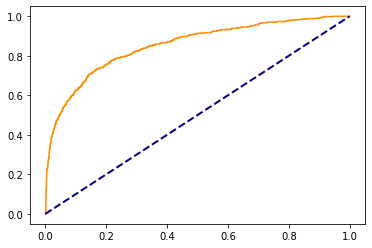

In [ ]:
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

def get_threshold(y_true, y_pred):
  min_val = -10
  max_val = 10

  while np.abs(max_val - min_val) > 1e-4:
      current_thresh = (max_val + min_val)/2

      if recall_score(y_true, y_pred > current_thresh) > 0.8:
          min_val = current_thresh
      else:
          max_val = current_thresh
  print(recall_score(y_true, y_pred > current_thresh))
  return current_thresh

def test_model(model, loader):
  model.eval()
  y_pred_list = []
  y_gt = []
  y_texts = []
  with torch.no_grad():
    for i, data in enumerate(loader, 0):
      inputs, labels, texts = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      y_pred = torch.sigmoid(outputs)
      y_pred_list.extend(y_pred)
      y_gt.extend(labels)
      y_texts.extend(texts)

  y_pred_list = torch.tensor(y_pred_list)
  y_gt = torch.tensor(y_gt)
  
  return y_gt, y_pred_list, y_texts

y_true, y_pred, y_texts = test_model(model, testloader)
y_true = torch.tensor(y_true).to(device)
y_pred = torch.tensor(y_pred).to(device)

threshold = torch.tensor([0.7]).to(device)

predictions = (y_pred>threshold).float()*1

acc = accuracy_score(y_true, predictions)


auc = roc_auc_score(y_true,y_pred)

print("ACCURACY: ", acc)
print(bootstrap((y_true, predictions), accuracy_score, vectorized = False, paired = True, random_state = 42, method = "basic", n_resamples = 1000))
print("AUC: ", auc)
print(bootstrap((y_true,y_pred > threshold), roc_auc_score, vectorized = False, paired = True, random_state = 42, method = "basic", n_resamples = 1000))

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
plt.plot(fpr,tpr, color='darkorange')
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# predictions_test = (y_pred>torch.tensor(.7)).float()*1
cm = confusion_matrix(y_true, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
# predictions_higher_threshold = (y_pred>torch.tensor(.7)).float()*1
# predictions_higher_threshold